## QLearning + non linear function approximation


Q-Networks make use of neural networks to approximate the Q-function. 

They use a norn linear function approximation to estimate the Q-function.
A Q-Network can be trained by iteratively minimizing the loss functions $L_i(\theta_i)$


Essentially, we want to transform our problem into a classficication problem, where the classes are the actions (actually the output is the Qvalue given by taking a certain action $a$, being in state $s$) and the features are the states.


1. State and action representation: Define a suitable representation for the state and action space.

2. Choose a non-linear function approximator: Select a non-linear function approximator that fits your problem, such as decision trees, SVMs, or KNN.

3. Initialize the function approximator: Initialize the chosen non-linear function approximator with appropriate parameters.

4. Collect training data: Execute actions in the environment using an exploration policy (e.g., epsilon-greedy) to collect state-action pairs and their resulting rewards.

5. Compute target Q-values: Use the Bellman equation and the collected data to compute the target Q-values. For each state-action pair, the target Q-value is the sum of the immediate reward and the maximum Q-value of the next state.

6. Train the function approximator: Use the collected state-action pairs and their corresponding target Q-values to train the function approximator using supervised learning or regression. Adjust the parameters of the function approximator to minimize the discrepancy between predicted and target Q-values.

This approach leverages the target Q-values derived from the Bellman equation and trains the non-linear function approximator to minimize the difference between the predicted and target Q-values using supervised learning or regression techniques.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import sys
import copy
from tqdm import tqdm

from qlearning import *
from qnetworks import *

### State aggregation - Learning from already saved policy

In [34]:
# initialize the environment and retrieve the policy already learned
Lx = 10
Ly = 10

env = GridWorldEnv(Lx,Ly)

# load policy from file
with open('policy.pkl', 'rb') as f:
    agent = pickle.load(f)
env.policy = agent.policy
env.values = agent.values

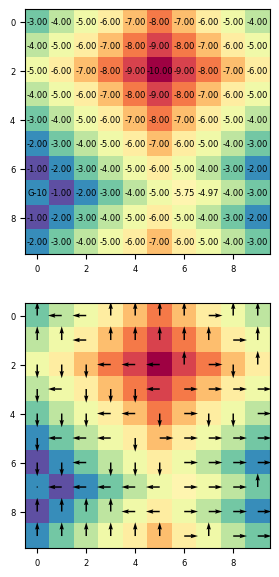

In [134]:
# show policy for one reward position
env.render_policy(goal_idx=70) # random index for reward

Can we use the policies we learnt to train a neural network to approximate the Q-function?

We have 10000 possible configurations that we can use as dataset. We use them with the associated learned policy to build the dataset to be used to train our neural network.

In [97]:
# inputs are all the possible configurations of the game
# state = (i,j, goal_i, goal_j)
# labels are the actions to take
inputs = np.zeros((Lx*Ly*Lx*Ly,4))
labels = np.zeros((Lx*Ly*Lx*Ly,4)) #one hot encoding
arr = []
count = 0
for i in range(Ly):
    for j in range(Lx):
        for goal_i in range(Ly):
            for goal_j in range(Lx):
                state = np.array([i,j,goal_i,goal_j])
                inputs[count,:] = state
                goal_idx = goal_i*Ly + goal_j
                
                if i == goal_i and j == goal_j:
                    arr.append(int(env.policy[i,j,goal_idx]))
                else:
                    labels[count, int(env.policy[i,j,goal_idx])] = 1
                count += 1

In [98]:
# normalize inputs
inputs = inputs/np.max(inputs)
# construct tensor datasets
inputs = torch.from_numpy(inputs).float()
labels = torch.from_numpy(labels).float()

# add small random noise to inputs for each row
inputs = inputs + 0.001*torch.randn(inputs.shape)

In [41]:
print(inputs.shape)
print(labels.shape)

torch.Size([10000, 4])
torch.Size([10000, 4])


In [102]:
# build dataloader
dataset = customDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [101]:
# initialize the network 
# a simple neural network with just one hidden layer
model = QNetwork(4, 4, 42)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

QNetwork(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=4, bias=True)
)


In [103]:
n_epochs = 1000
model.train()

# train the network
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    size = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs and labels
        state, action = data
        state = state.float()
        action = action.float()

        
        size += state.shape[0]
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(state)
        
        loss = criterion(outputs, action)
        loss.backward()
        optimizer.step()
        #scheduler.step()

        # print statistics
        running_loss += loss.item()
        
    if  epoch % 100 == 0:   
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / size:.3f}')
        running_loss = 0.0


[1,   157] loss: 0.022
[101,   157] loss: 0.019
[201,   157] loss: 0.018
[301,   157] loss: 0.018
[401,   157] loss: 0.017
[501,   157] loss: 0.017
[601,   157] loss: 0.017
[701,   157] loss: 0.017
[801,   157] loss: 0.017
[901,   157] loss: 0.017


In [2]:
def plot_policy(goal_idx, policy, Lx, Ly):
        
    # get coordinates of the goal
    # find coordinates of the goal
    # idx = i*self.Ly+j find i,j
    i = goal_idx//Ly
    j = goal_idx% Ly
    goal = [i,j]

    fig, ax = plt.subplots()


    World = np.zeros((Lx,Ly))
    actions = np.array([[1,0],[-1,0],[0,1],[0,-1]])

    # Optimal policy for QLearning as arrows for plots
    optimal_policy_arrows_QLearning = np.zeros( (*World.shape, 2) )
    optimal_policy_arrows_QLearning[:,:] = actions[ policy ]

    im = ax.imshow(World, cmap=plt.get_cmap("Spectral"))
    X = np.arange(Lx)
    Y = np.arange(Ly)

    optimal_policy_arrows_QLearning[goal[0], goal[1]] = 0
        
    U, V = optimal_policy_arrows_QLearning[:,:,1], -optimal_policy_arrows_QLearning[:,:,0]
    q = ax.quiver(X, Y, U, V, color="black")

    plt.show()

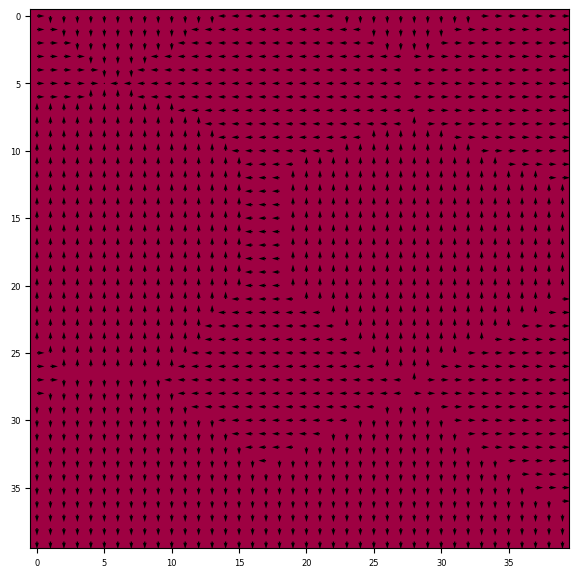

In [136]:
# get the policy which corresponds to a certain end state and plot it
lx_new = 40
ly_new = 40
policy = np.zeros((ly_new,lx_new))
values = np.zeros((ly_new,lx_new))

end = [5,5]
model.eval()

for i in range(ly_new):
    for j in range(lx_new):
        input = torch.tensor([i,j,end[0],end[1]]).unsqueeze(0)
        # normalize input
        input = input/(lx_new-1)
        
        #print(input)
        output = model(input.float())
        policy[i,j] = torch.argmax(output).item()


# plot the policy
plot_policy(end[0]*ly_new + end[1], policy.astype(int), lx_new, ly_new)


In [ ]:
# save model
#torch.save(model.state_dict(), 'model.pt')

### Real QLearning with neural networks

Below, we see how to integrate neural networks in the QLearning algorithm, while we are learning Qvalues exploiting and exploring the results of single episodes.

In [17]:
# initialize the environment and retrieve the policy already learned
Lx = 10
Ly = 10

env = GridWorldEnv(Lx,Ly)

In [18]:
num_features = 4
num_actions = 4
action_space = np.arange(num_actions)
seed = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [19]:
qlearnNN = QLearnNN(num_features, num_actions).to(device)

optimizer = torch.optim.Adam(qlearnNN.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [20]:
def select_epsilon_greedy_action(state, epsilon):
  """
  Take random action with probability epsilon, 
  else take best action.
  """
  result = np.random.uniform()
  if result < epsilon:
    return np.random.choice(action_space) 
  else:
    # input is a tensor of floats
    input = torch.as_tensor(state, dtype=torch.float32)
    # normalize input
    input = input/(Lx-1)
    qs = qlearnNN(input).cpu().data.numpy()
    return np.argmax(qs) # Greedy action for state.

In [21]:
def train_step(states, actions, rewards, next_states, dones, discount):
    """
    Perform a training iteration on a batch of data sampled from the experience
    replay buffer.
    """

    # compute targets for Q-learning
    # the max Q-value of the next state is the target for the current state
    input = torch.as_tensor(next_states, dtype=torch.float32)
    # normalize input
    input = input/(Lx-1)
    max_next_qs = qlearnNN(input).max(-1).values
    target = rewards + (1.0 - dones) * discount * max_next_qs

    # then to compute the loss, we also need the Q-value of the current state
    input = torch.as_tensor(states, dtype=torch.float32)
    input = input/(Lx-1)
    qs = qlearnNN(input)

    action_masks = F.one_hot(torch.as_tensor(actions).long(), num_actions)
    masked_qs = (action_masks * qs).sum(dim=-1)
    loss = loss_fn(masked_qs, target.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [22]:
def single_step(env, state, action):
    """
    Evolves the environment given action A and current state.
    """
    actions = np.array([[1,0],[-1,0],[0,1],[0,-1]]) 
    a = actions[action]
    S = copy.deepcopy(state)
    S_new = S
    S_new[:2] += a

    
    # add a penalty for moving
    reward = -1

    # If we go out of the world, we enter from the other side
    if (S_new[0] == env.Ly):
        S_new[0] = 0
    elif (S_new[0] == -1):
        S_new[0] = env.Ly - 1
    elif (S_new[1] == env.Lx):
        S_new[1] = 0
    elif (S_new[1] == -1):
        S_new[1] = env.Lx - 1
    
    elif np.all(S_new[:2] == S_new[2:]):
        env.done = True         
    
    # Save in memory new position
    env.current_state = S_new[:2]
    return S_new, reward, env.done

In [23]:
# Hyperparameters.
num_episodes = 20000
epsilon = 1.0
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000, device=device)
cur_frame = 0

qlearnNN.train()

# Start training. Play game once and then train with a batch.
last_100_ep_rewards = []
all_states = []
for episode in tqdm(range(num_episodes+1)):
  env.reset()
  # state is a random tuple of 4 values
  # made of starting position and goal position
  start_x = np.random.randint(0,Lx)
  start_y = np.random.randint(0,Ly)
  if episode % 10 == 0: # every 10 episodes, change the goal
    goal_x = np.random.randint(0,Lx)
    goal_y = np.random.randint(0,Ly)
    
  state = [start_x, start_y, goal_x, goal_y]

  all_states.append(state)
  ep_reward, done = 0, False

  while not done:
    
    state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
    action = select_epsilon_greedy_action(state_in, epsilon)
    
    next_state, reward, done = single_step(env, state, action)
    ep_reward += reward
    
    
    # Save to experience replay.
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1
 
    # Train neural network.
    if len(buffer) > batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      loss = train_step(states, actions, rewards, next_states, dones, discount)
    
  if episode % 200 == 0:
    epsilon -= 0.01

  if len(last_100_ep_rewards) == 100:
    last_100_ep_rewards = last_100_ep_rewards[1:]
  last_100_ep_rewards.append(ep_reward)

  if episode % 1000 == 0:
    print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}.'
          f' Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.2f}')
    


  0%|          | 1/20001 [00:00<1:25:00,  3.92it/s]

Episode 0/20000. Epsilon: 0.990. Reward in last 100 episodes: -142.00


  5%|▌         | 1001/20001 [06:29<3:36:28,  1.46it/s]

Episode 1000/20000. Epsilon: 0.940. Reward in last 100 episodes: -186.71


 10%|█         | 2001/20001 [11:25<38:37,  7.77it/s]  

Episode 2000/20000. Epsilon: 0.890. Reward in last 100 episodes: -124.30


 15%|█▍        | 3000/20001 [13:43<29:10,  9.71it/s]  

Episode 3000/20000. Epsilon: 0.840. Reward in last 100 episodes: -53.27


 20%|██        | 4003/20001 [15:10<14:49, 17.98it/s]  

Episode 4000/20000. Epsilon: 0.790. Reward in last 100 episodes: -37.49


 25%|██▌       | 5002/20001 [16:14<12:22, 20.21it/s]

Episode 5000/20000. Epsilon: 0.740. Reward in last 100 episodes: -29.07


 30%|███       | 6004/20001 [17:03<09:44, 23.96it/s]

Episode 6000/20000. Epsilon: 0.690. Reward in last 100 episodes: -25.60


 35%|███▌      | 7002/20001 [17:44<09:08, 23.68it/s]

Episode 7000/20000. Epsilon: 0.640. Reward in last 100 episodes: -21.92


 40%|████      | 8007/20001 [18:19<05:50, 34.21it/s]

Episode 8000/20000. Epsilon: 0.590. Reward in last 100 episodes: -17.11


 45%|████▌     | 9006/20001 [18:47<03:56, 46.43it/s]

Episode 9000/20000. Epsilon: 0.540. Reward in last 100 episodes: -13.20


 50%|█████     | 10009/20001 [19:12<04:11, 39.68it/s]

Episode 10000/20000. Epsilon: 0.490. Reward in last 100 episodes: -12.61


 55%|█████▌    | 11006/20001 [19:35<03:07, 48.10it/s]

Episode 11000/20000. Epsilon: 0.440. Reward in last 100 episodes: -9.61


 60%|██████    | 12011/20001 [19:56<02:32, 52.31it/s]

Episode 12000/20000. Epsilon: 0.390. Reward in last 100 episodes: -9.30


 65%|██████▌   | 13015/20001 [20:13<01:34, 74.07it/s]

Episode 13000/20000. Epsilon: 0.340. Reward in last 100 episodes: -8.16


 70%|███████   | 14015/20001 [20:28<01:21, 73.65it/s]

Episode 14000/20000. Epsilon: 0.290. Reward in last 100 episodes: -7.64


 75%|███████▌  | 15016/20001 [20:43<01:04, 77.36it/s]

Episode 15000/20000. Epsilon: 0.240. Reward in last 100 episodes: -7.42


 80%|████████  | 16015/20001 [20:57<00:50, 78.71it/s]

Episode 16000/20000. Epsilon: 0.190. Reward in last 100 episodes: -6.78


 85%|████████▌ | 17011/20001 [21:09<00:37, 78.82it/s] 

Episode 17000/20000. Epsilon: 0.140. Reward in last 100 episodes: -6.46


 90%|█████████ | 18016/20001 [21:22<00:23, 85.01it/s] 

Episode 18000/20000. Epsilon: 0.090. Reward in last 100 episodes: -5.80


 95%|█████████▌| 19008/20001 [21:32<00:10, 95.38it/s] 

Episode 19000/20000. Epsilon: 0.040. Reward in last 100 episodes: -5.69


100%|██████████| 20001/20001 [21:43<00:00, 15.35it/s] 

Episode 20000/20000. Epsilon: -0.010. Reward in last 100 episodes: -5.04


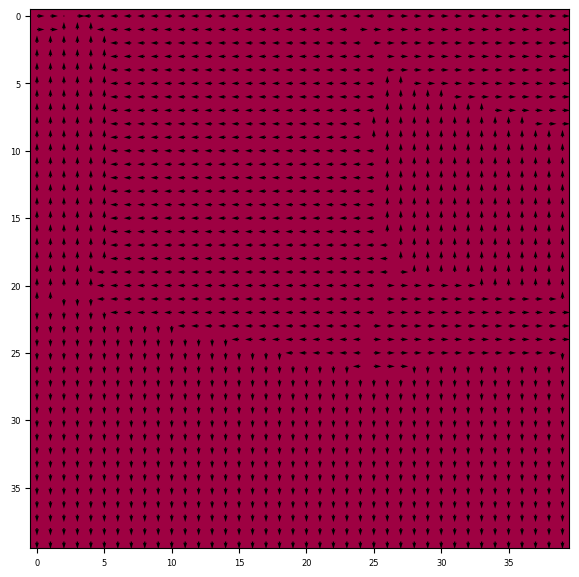

In [24]:
# get the policy which corresponds to a certain end state and plot it
lx_new = 40
ly_new = 40
policy = np.zeros((ly_new,lx_new))
values = np.zeros((ly_new,lx_new))

end = [0,2]
qlearnNN.eval()

for i in range(ly_new):
    for j in range(lx_new):
        input = torch.tensor([i,j,end[0],end[1]]).unsqueeze(0)
        # normalize input
        input = input/(lx_new-1)
        output = qlearnNN(input.float())
        policy[i,j] = torch.argmax(output).item()


# plot the policy
plot_policy(end[0]*ly_new + end[1], policy.astype(int), lx_new, ly_new)


In [25]:
# save the model
# torch.save(qlearnNN.state_dict(), 'qlearnNN.pt')